In [23]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [24]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [25]:
# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=False,
    train=True,
    transform=transform)
print(' Number of training data ', len(trainset))

 Number of training data  60000


In [26]:
testset = torchvision.datasets.FashionMNIST('./data',
    download=False,
    train=False,
    transform=transform)
print(' Number of testing data ',len(testset))

 Number of testing data  10000


In [27]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [28]:
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [29]:
cnn_layers =  nn.Sequential(
            # Defining a 2D convolution layer
            # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
            # in_channels (int) – Number of channels in the input image. For B&W it is 1.
            # out_channels (int) – Number of channels produced by the convolution. 4 filters
            # kernel_size (int or tuple) – Size of the convolving kernel (3x3)
            # stride (int or tuple, optional) – Stride of the convolution
            # padding (int or tuple, optional) – Padding of 1 added to both sides of the input
            # example x1 = (n, c=1 , h=28 , w=28 )
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1), #in_channels = 1 is a data dependent hyperparameter. It is 1 because the images are in grayscale
            # x2 = (n, c=4 , h=28 , w=28 )
            nn.BatchNorm2d(4), # Normalize output from the activation function. 
            nn.ReLU(inplace=True), # negative elements to zero
            # x2 = (n, c=4 , h=28 , w=28 )
            nn.MaxPool2d(kernel_size=2, stride=2), #Stride is the number of pixels shifts over the input matrix. When the stride is 1 then we move the filters to 1 pixel at a time. When the stride is 2 then we move the filters to 2 pixels at a time and so on
            # x3 = (n, c=4 , h=14 , w=14 )
            # Defining another 2D convolution layer
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            # x3 = (n, c=4 , h=14 , w=14 )
            nn.BatchNorm2d(4), # 4 features
            nn.ReLU(inplace=True), # inplace = True will modify the input directly, without allocating any additional output.
            # x3 = (n, c=4 , h=14 , w=14 )
            nn.MaxPool2d(kernel_size=2, stride=2), # Downsamples the input representation by taking the maximum value
            # x4 = (n, c=4 , h=7 , w=7 )
        )
        # outputSize = floor[(inputSize - filterSize + 2 * padding) / stride] + 1
print(cnn_layers)

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [30]:
linear_layers = nn.Sequential(
            nn.Linear(4 * 7 * 7, 10) 
#10 outputs because MNIST Fashion has 10 different classes. It is a data dependent hyperparameter

)

print(linear_layers)

Sequential(
  (0): Linear(in_features=196, out_features=10, bias=True)
)


In [31]:
test_input = torch.ones([1000,1,28,28])

In [32]:
cnn_result = cnn_layers(test_input)
print(cnn_result.shape)
print('flattened layer input size', 1000 , 'x' , cnn_result.view(1000,-1).shape[1])

torch.Size([1000, 4, 7, 7])
flattened layer input size 1000 x 196


In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layer = cnn_layers
        self.linear_layer = linear_layers
    
    def forward(self, x):
        x = self.cnn_layer(x)
        x = x.view(x.shape[0],-1)
        x = self.linear_layer(x)
        return x

In [34]:
net = Net()
net.forward(test_input).shape

torch.Size([1000, 10])

In [35]:
optimizer =  optim.Adam(net.parameters(), lr=0.07) # learning rate 
# defining the loss function
criterion =  nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    print('cuda is available')
    net = net.cuda()
    criterion = criterion.cuda()

cuda is available


In [36]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

torch.Size([4, 1, 28, 28])


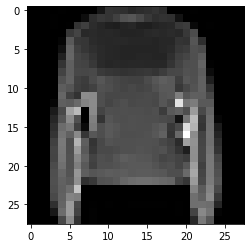

In [37]:
import numpy as np
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)), cmap='gray')

In [38]:
epochs = 10 

In [56]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.324
[1,  4000] loss: 2.328
[1,  6000] loss: 2.330
[1,  8000] loss: 2.328
[1, 10000] loss: 2.328
[1, 12000] loss: 2.329
[1, 14000] loss: 2.332
[2,  2000] loss: 2.328
[2,  4000] loss: 2.328
[2,  6000] loss: 2.329
[2,  8000] loss: 2.328
[2, 10000] loss: 2.329
[2, 12000] loss: 2.329
[2, 14000] loss: 2.330
[3,  2000] loss: 2.325
[3,  4000] loss: 2.326
[3,  6000] loss: 2.327
[3,  8000] loss: 2.327
[3, 10000] loss: 2.328
[3, 12000] loss: 2.327
[3, 14000] loss: 2.329
[4,  2000] loss: 2.328
[4,  4000] loss: 2.328
[4,  6000] loss: 2.330
[4,  8000] loss: 2.329
[4, 10000] loss: 2.329
[4, 12000] loss: 2.330
[4, 14000] loss: 2.328
[5,  2000] loss: 2.328
[5,  4000] loss: 2.331
[5,  6000] loss: 2.329
[5,  8000] loss: 2.327
[5, 10000] loss: 2.328
[5, 12000] loss: 2.328
[5, 14000] loss: 2.331
[6,  2000] loss: 2.327
[6,  4000] loss: 2.329
[6,  6000] loss: 2.329
[6,  8000] loss: 2.329
[6, 10000] loss: 2.329
[6, 12000] loss: 2.332
[6, 14000] loss: 2.329
[7,  2000] loss: 2.327
[7,  4000] 

In [63]:
print(outputs[1])
print(torch.max(outputs[0]))
torch.topk(outputs,k=2, dim=1)

tensor([ 0.4464,  0.1405, -0.3777, -0.0677,  0.0247,  0.1026, -0.5148,  0.2474,
         0.2994,  0.1011], device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.4464, device='cuda:0', grad_fn=<MaxBackward1>)


torch.return_types.topk(
values=tensor([[0.4464, 0.2994],
        [0.4464, 0.2994],
        [0.4464, 0.2994],
        [0.4464, 0.2994]], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([[0, 8],
        [0, 8],
        [0, 8],
        [0, 8]], device='cuda:0'))

In [19]:
PATH = './fmnist_test.pth'
torch.save(net.state_dict(), PATH)

In [20]:
loadNet = Net()
loadNet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [21]:
print(loadNet)

Net(
  (cnn_layer): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


<generator object Module.children at 0x00000199137A4430>
torch.Size([4, 1, 3, 3])


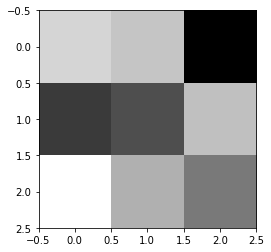

In [22]:
model_children = loadNet.children()
print(model_children)
filters = list(model_children)[0][0].weight
print(filters.shape)
plt.imshow(np.transpose(filters[0].cpu().detach().numpy(), (1, 2, 0)), cmap='gray')